In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

import gpytorch
from twinLab import *

In [2]:
parameters = pd.read_csv('parameters.csv')

In [3]:
#n_samples = parameters.shape[0]
#
#model_output = []
#
#for i in range(n_samples):
#    s = pd.read_csv('samples/sample_{}.csv'.format(i))[['temperature', 'desorption_rate']]
#    model_output.append(s)
#    
#grid_projection = Linear1dProjection()
#grid, samples_grid = grid_projection.transform(model_output)
#
#np.savetxt('grid.csv', grid)
#np.savetxt('samples_grid.csv', samples_grid)

In [4]:
grid = np.loadtxt('grid.csv')
samples_grid = np.loadtxt('samples_grid.csv')

In [5]:
#estimator = MultiOutputGPRegressor(GaussianProcessRegressor(kernel=RBF(length_scale_bounds=(0.1,10))), n_jobs=-1)

mean = gpytorch.means.ZeroMean
kernel = gpytorch.kernels.RBFKernel
kernel_kwargs = {'ard_num_dims': parameters.shape[1]}
estimator = MultiExactGPModel(mean, kernel, kernel_kwargs=kernel_kwargs)

input_transformers = [StandardScaler()]
output_transformers = [IsotropicStandardScaler(), TruncatedSVD(8), StandardScaler()]

pipeline = Pipeline(estimator, input_transformers, output_transformers)

In [6]:
training_proportion = 0.8
n_train = int(training_proportion*4096)

indices = np.random.permutation(parameters.shape[0])
train_idx, test_idx = indices[:n_train], indices[n_train:]

x_train = parameters.values[train_idx,:]
y_train = samples_grid[train_idx,:]

x_test = parameters.values[test_idx,:]
y_test = samples_grid[test_idx,:]

pipeline.fit(x_train, y_train)


Training GP 1/8...
Iteration 10/100: Loss: 0.807, Length scale: 1.218, Noise: 0.340
Iteration 20/100: Loss: 0.332, Length scale: 1.804, Noise: 0.135
Iteration 30/100: Loss: -0.170, Length scale: 2.236, Noise: 0.049
Iteration 40/100: Loss: -0.665, Length scale: 2.583, Noise: 0.018
Iteration 50/100: Loss: -1.122, Length scale: 2.913, Noise: 0.007
Iteration 60/100: Loss: -1.489, Length scale: 3.185, Noise: 0.003
Iteration 70/100: Loss: -1.729, Length scale: 3.407, Noise: 0.002
Iteration 80/100: Loss: -1.855, Length scale: 3.604, Noise: 0.001
Iteration 90/100: Loss: -1.934, Length scale: 3.744, Noise: 0.001
Iteration 100/100: Loss: -1.965, Length scale: 3.900, Noise: 0.001

Training GP 2/8...
Iteration 10/100: Loss: 0.805, Length scale: 1.213, Noise: 0.340
Iteration 20/100: Loss: 0.330, Length scale: 1.740, Noise: 0.135
Iteration 30/100: Loss: -0.163, Length scale: 2.127, Noise: 0.049
Iteration 40/100: Loss: -0.651, Length scale: 2.484, Noise: 0.018
Iteration 50/100: Loss: -1.097, Length 

1543


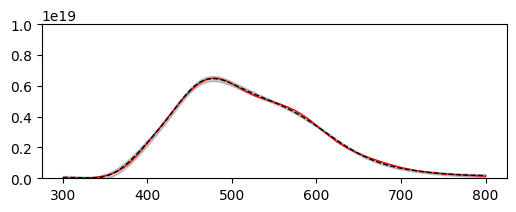

2456


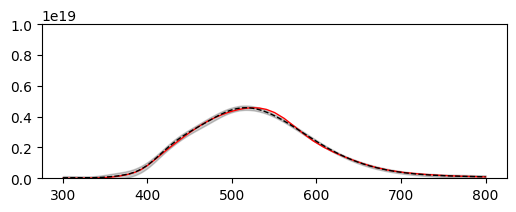

1599


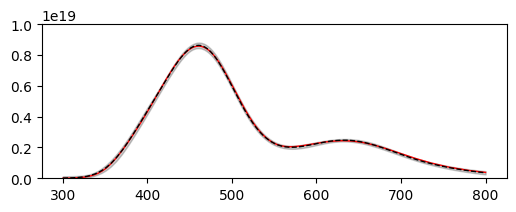

3508


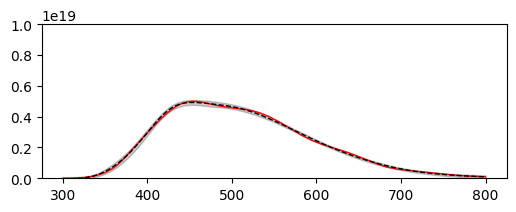

3003


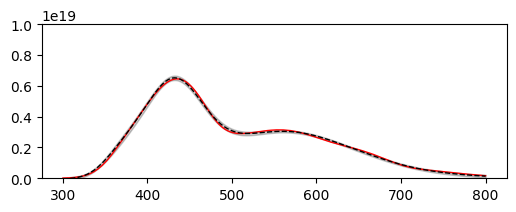

1152


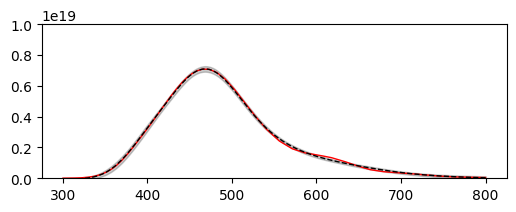

1593


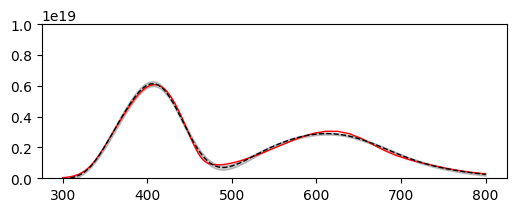

2316


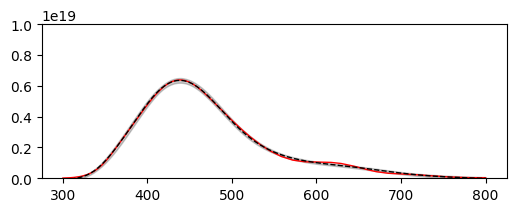

1072


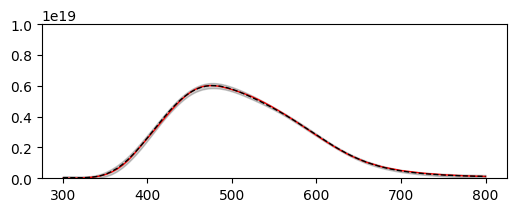

96


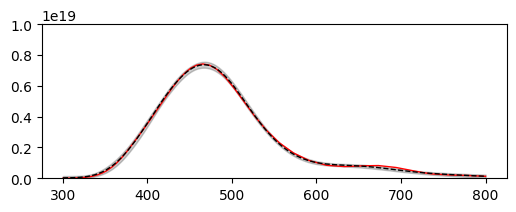

In [7]:
for i in range(10):
    
    idx = np.random.choice(test_idx)
    print(idx)
    
    plt.figure(figsize=(6,2))
    plt.plot(grid, samples_grid[idx,:], c='r', linewidth=1)
    
    mean, stdev = pipeline.predict(parameters.values[idx,:][np.newaxis,:])
    #mean, stdev = pipeline.predict(parameters_norm[idx,:][np.newaxis,:])
    plt.plot(grid, mean.flatten(), c='k', linewidth=1, linestyle='dashed')
    plt.fill_between(grid, mean.flatten()-1.96*stdev.flatten(), mean.flatten()+1.96*stdev.flatten(), alpha=0.2, color='k')
    plt.ylim(0, 1e19)
    
    #plt.savefig('plots/sample{}.pdf'.format(i), bbox_inches='tight')
    plt.show()

In [8]:
pipeline.save('pipeline.pickle')